# Kuzushiji Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for image classification. We will use a variant of the famous MNIST dataset (the original is a dataset of handwritten digits). The version we are going to use is called Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) and is a dataset of traditional japanese handwritten kana.



The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
kuzushiji_symbols = ['お', 'き', 'す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を']

## TODO: Insert your surname, name and ID number

Student surname: Zomer

Student name: Nicola 
    
ID: 2058479

In [2]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as skm

In [3]:
# helper function to load Kuzushiji-MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [4]:
#fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)
ID = 2058479
np.random.seed(ID)

In [5]:
#load the K-MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1] 

X, y = load_mnist('data', kind='train')
# rescale the data
X, y = X / 255., y # original pixel values are between 0 and 255
print(X.shape, y.shape)
print(X.dtype, y.dtype)

# 60000 samples, each featuring 784 pixels

(60000, 784) (60000,)
float64 uint8


Now split into training and test. Make sure that each label is present at least 10 times
in training. If it is not, then keep adding permutations to the initial data until this 
happens.

In [6]:
# FUNCTION FOR CHECKING IF EACH UNIQUE LABEL APPEARS IN THE ARRAY A MINIMUM NUMBER OF TIMES

def check_minimum_labels(Y, minimum):
    # Y has to be a np array
    labels = np.unique(Y)
    for label in labels:
        if np.sum(Y==label) < minimum:
            return False
    return True   

In [7]:
# Random permute the data and split into training and test taking the first 
# 600 data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

# we don't use the whole dataset
m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

while not check_minimum_labels(y_train, 10):
    permutation = np.random.permutation(X.shape[0]) # again random permutation
    
    X = X[permutation]
    y = y[permutation]
    
    X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
    y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)
# If 'return_counts' is True, also return the number of times each unique item appears in the array
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [61 47 58 73 67 59 59 66 56 54]


In [8]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("LABEL: %i"%labels[index])
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    return

LABEL: 0
INPUT:


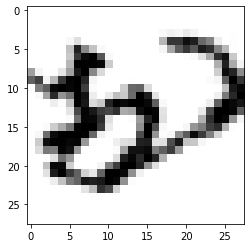

LABEL: 0
INPUT:


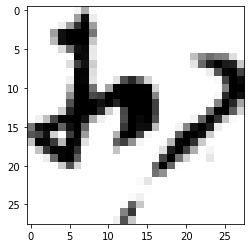

LABEL: 0
INPUT:


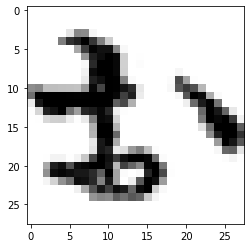

LABEL: 9
INPUT:


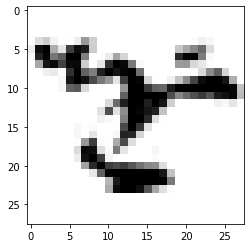

In [9]:
#let's try the plotting function
plot_input(X_train,y_train,5)
plot_input(X_test,y_test,50)
plot_input(X_test,y_test,500)
plot_input(X_test,y_test,700)

## TO DO 1
Use a SVM classifier with cross validation to pick a model. Use a **4-fold cross-validation**. Let's start with a Linear kernel:

In [10]:
#import SVC
from sklearn.svm import SVC
#import for Cross-vcValidation
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [11]:
# parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1, 10]}

# train linear SVM
svc = SVC(kernel = 'linear')
lin_clf = GridSearchCV(svc, parameters, cv=4)  # cv is an integer, to specify the number of folds in a KFold (default is 5)
lin_model = lin_clf.fit(X_train, y_train)

print ('RESULTS FOR LINEAR KERNEL')
print("Best parameters set found:")
print(lin_model.best_params_)

print("\nScore with best parameters:")
print(lin_model.best_score_)

print("\nAll scores on the grid:")
# params_comb = lin_model.cv_results_['params']
mean_scores = lin_model.cv_results_['mean_test_score']

df = pd.DataFrame({'C': parameters['C'], 'mean score': mean_scores})
df.style.highlight_max(subset='mean score', props='color:lightgray; font-weight:bold; background-color:darkblue;')

RESULTS FOR LINEAR KERNEL
Best parameters set found:
{'C': 0.01}

Score with best parameters:
0.73

All scores on the grid:


,C,mean score
0,0.010000,0.730000
1,0.100000,0.728333
2,1.000000,0.725000
3,10.000000,0.725000


## TO DO 2
Pick a model for the Polynomial kernel with degree=2:

In [12]:
# parameters for poly with degree 2 kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1]}

# run SVM with poly of degree 2 kernel

svc = SVC(kernel = 'poly', degree = 2)
deg2_clf = GridSearchCV(svc, parameters, cv=4)
deg2_model = deg2_clf.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')
print("Best parameters set found:")
print(deg2_model.best_params_)

print("\nScore with best parameters:")
print(deg2_model.best_score_)

print("\nAll scores on the grid:")
params_comb = deg2_model.cv_results_['params']
mean_scores = deg2_model.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df.style.highlight_max(subset='mean score', props='color:lightgray; font-weight:bold; background-color:darkblue;')


RESULTS FOR POLY DEGREE=2 KERNEL
Best parameters set found:
{'C': 0.01, 'gamma': 1}

Score with best parameters:
0.7766666666666667

All scores on the grid:


,C,gamma,mean score
0,0.010000,0.010000,0.121667
1,0.010000,0.100000,0.748333
2,0.010000,1.000000,0.776667
3,0.100000,0.010000,0.523333
4,0.100000,0.100000,0.776667
5,0.100000,1.000000,0.776667
6,1.000000,0.010000,0.748333
7,1.000000,0.100000,0.776667
8,1.000000,1.000000,0.776667


## TO DO 3

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [13]:
# parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1]}

#run SVM with poly of higher degree kernel
deg = 3

svc = SVC(kernel = 'poly', degree=deg)
deg3_clf = GridSearchCV(svc, parameters, cv=4)
deg3_model = deg3_clf.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=', deg, ' KERNEL')
print("Best parameters set found:")
print(deg3_model.best_params_)

print("\nScore with best parameters:")
print(deg3_model.best_score_)

print("\nAll scores on the grid:")
params_comb = deg3_model.cv_results_['params']
mean_scores = deg3_model.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df.style.highlight_max(subset='mean score', props='color:lightgray; font-weight:bold; background-color:darkblue;')

RESULTS FOR POLY DEGREE= 3  KERNEL
Best parameters set found:
{'C': 0.01, 'gamma': 0.1}

Score with best parameters:
0.73

All scores on the grid:


,C,gamma,mean score
0,0.010000,0.010000,0.121667
1,0.010000,0.100000,0.730000
2,0.010000,1.000000,0.706667
3,0.100000,0.010000,0.406667
4,0.100000,0.100000,0.705000
5,0.100000,1.000000,0.706667
6,1.000000,0.010000,0.716667
7,1.000000,0.100000,0.706667
8,1.000000,1.000000,0.706667


## TO DO 4
Pick a model for the Radial Basis Function kernel:

In [14]:
# parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

#run SVM with rbf kernel

svc = SVC(kernel = 'rbf')
rbf_clf = GridSearchCV(svc, parameters, cv=4)
rbf_model = rbf_clf.fit(X_train, y_train)

print ('RESULTS FOR rbf KERNEL')
print("Best parameters set found:")
print(rbf_model.best_params_)

print("\nScore with best parameters:")
print(rbf_model.best_score_)

print("\nAll scores on the grid:")
params_comb = rbf_model.cv_results_['params']
mean_scores = rbf_model.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df.style.highlight_max(subset='mean score', props='color:lightgray; font-weight:bold; background-color:darkblue;')

RESULTS FOR rbf KERNEL
Best parameters set found:
{'C': 10, 'gamma': 0.01}

Score with best parameters:
0.7999999999999999

All scores on the grid:


,C,gamma,mean score
0,0.100000,0.001000,0.121667
1,0.100000,0.010000,0.155000
2,0.100000,0.100000,0.121667
3,0.100000,1.000000,0.121667
4,1.000000,0.001000,0.641667
5,1.000000,0.010000,0.773333
6,1.000000,0.100000,0.131667
7,1.000000,1.000000,0.121667
8,10.000000,0.001000,0.746667
9,10.000000,0.010000,0.800000


## QUESTION 1
> What do you observe when using linear, polynomial and RBF kernels on this dataset ?

First of all, the SVM kernel that produces the best results is RBF, with parameters: 
- $C = 10$
- $\gamma = 0.01$

**Linear Kernel** <br>
With the linear kernel, the scores on the grid are all very similar $(\simeq 0.73)$, so focusing more on the margin or on avoiding error does not affect very much the result. The best score is obtained with $C=0.01$. 

**Polynomial kernel** <br>
We trained both the polynomial kernel with degree 2 and with degree 3 with the same parameters:
- $C=\{0.01, 0.1, 1\}$
- $\gamma = \{0.01,0.1,1\}$

**Degree 2** <br>
In this case the best result is obtained with $C = 0.01$ and $\gamma = 1$. The mean scores are still all very similar and close to the best one (of this model), except for those obtained with
- $C = 0.01, \gamma = 0.01$  &#8594; score: $0.121667$
- $C = 0.1, \gamma = 0.01$  &#8594; score: $0.523333$

Here the "critical" parameter is $\gamma$. Indeed, with these values of $C$ we also get good results (e.g. the best one), while in general the bigger is $\gamma$ the bigger is the mean score (fixed $C$). In particular, with $\gamma = 0.01$ (small), we are underfitting the data. 

Finally, the score with the best parameters is bigger than the one resulting from the linear model.  

**Degree 3** <br>
Using a degree 3 polynomial kernel produces similar results to those obtained with degree 2. Still $\gamma$ plays an important role. Indeed, with $\gamma=0.01$, the smaller possible value, we still get the worst results, due to underfitting the data. Moreover, as in the previous case, the scores greater than 0.5 are all very similar and close to the best one. 

However, with the degree 3 polynomial kernel the best score is smaller than with degree 2. 

Finally, fixed $C$, in this case it is not true that the bigger is $\gamma$ the bigger is the mean score. Indeed, the score slightly decreases passing from $\gamma = 0.1$ to $\gamma = 1$, meaning that in the last case we are a bit overfitting the data. 


**RBF Kernel** <br>
As expected, The RBF Kernel is the one that produces the best overall score: $0.8$. The parameters can assume these values:
- $C=\{0.1, 1, 10, 100\}$
- $\gamma = \{0.001, 0.01, 0.1,1\}$

In this final case, I notice that with $C=0.1$, we always get a very bad score, due to the fact that we are focusing too much on the margin and not on avoiding errors, and so underfitting the data. On the other hand, if we focus on $\gamma \geq 0.1$, for all possible values of $C$ we still have a very bad score, but in this case it is due to overfitting the data, meaning that the samples to be close need to be very close. 

The best trade off between a quite general solution and a solution that fits well the data is obtained with $C=10$ and $\gamma = 0.01$.


## TO DO 5
Report here the best SVM kernel and parameters

In [15]:
#get training and test error for the best SVM model from CV
models_print_list = ['linear', 'poly (degree 2)', 'poly (degree 3)', 'RBF']
kernels_list = ['linear', 'poly', 'poly', 'rbf']
degrees_list = {1: 2, 2: 3}
models_list = [lin_model, deg2_model, deg3_model, rbf_model]

index_best_SVM = np.argmax(np.array([models_list[i].best_score_ for i in range(4)]))
best_SVM = models_list[index_best_SVM]
best_param = best_SVM.best_params_
best_kern = kernels_list[index_best_SVM]

print('Best SVM model is', models_print_list[index_best_SVM], 'with parameters:', best_param)

# (error is 1 - svm.score)
training_error = 1 - best_SVM.score(X_train, y_train)
test_error = 1 - best_SVM.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

errors_SVM_600 = np.array([training_error, test_error])

Best SVM model is RBF with parameters: {'C': 10, 'gamma': 0.01}
Best SVM training error: 0.000000
Best SVM test error: 0.173500


## TO DO 6

Analyze how the **gamma parameter** (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [16]:
# Test with different values of gamma

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print('Gamma values:', *gamma_values)


Gamma values: 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0


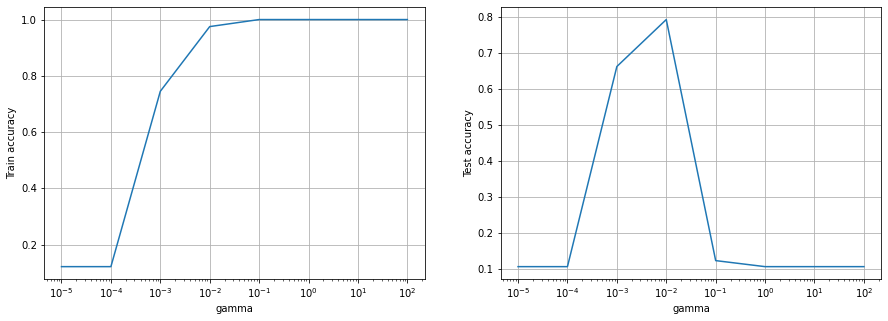

In [17]:
# Try the SVM with the previously set values of gamma
# use rbf kernel and C=1

train_acc_list, test_acc_list = [], []

# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS
for gamma in gamma_values:
    model = SVC(kernel = 'rbf', C=1, gamma = gamma)
    model.fit(X_train, y_train)
    train_acc_list.append(model.score(X_train, y_train))
    test_acc_list.append(model.score(X_test, y_test))
    
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)


plt.show()

## QUESTION 2
> How do the train and test error change when changing gamma? Which is the best value of gamma ? 
Connect your answers to the discussion about the overfitting issue.

When the value of $\gamma$ increases, the train error decreases monotonically, while the test error reaches a minimum and then starts to rapidly increase. This different behaviour is due to overfitting: when $\gamma$ is too big, the samples to be close need to be really close, so we are fitting the region over the samples. This leads, obviously, to a smaller training error, but to a bigger test error, because we are learning precisely the training data and not from them. <br>
On the other hand, at the beginning, both the accuracies are very small, meaning that we are underfitting the data.  

The best value of $\gamma$ is the one that minimizes the test error (i.e. maximizes the test accuracy), so $\gamma_{best} = 0.01$.

## More data
Now let's do the same but using more data points for training and all the remaining for testing. 


Choose a new number of data points.

In [18]:
X = X[permutation]
y = y[permutation]

m_training = 2000 # TODO number of data points, adjust depending on the capabilities of your PC

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [190 205 209 188 206 202 205 202 205 188]


## TO DO 7

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  2000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the cell below.

In [19]:
#get training and test error for the best SVM model from CV
print('Kernel:', best_kern)

if best_kern == 'poly':
    SVM_2000 = SVC(kernel = best_kern, degree=degrees_list[index_best_SVM], C = best_param['C'], gamma = best_param['gamma'])
elif best_kern == 'linear':
    SVM_2000 = SVC(kernel = best_kern, C = best_param['C'])
else:
    SVM_2000 = SVC(kernel = best_kern, C = best_param['C'], gamma = best_param['gamma'])
    
SVM_2000.fit(X_train, y_train)
training_error = 1-SVM_2000.score(X_train, y_train)
test_error = 1 - SVM_2000.score(X_test, y_test)

print ("\nBest SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

errors_SVM_2000 = np.array([training_error, test_error])

Kernel: rbf

Best SVM training error: 0.000000
Best SVM test error: 0.118966


Just for comparison, let's also use logistic regression 

## TO DO 8 Try first without regularization (use a very large large C)¶

In [20]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, max_iter=1000)
logreg.fit(X_train, y_train)

training_error = 1-logreg.score(X_train, y_train)
test_error = 1 - logreg.score(X_test, y_test)

print ("Best logistic regression training error: %f" % training_error)
print ("Best logistic regression test error: %f" % test_error)

errors_LR= np.array([training_error, test_error])

Best logistic regression training error: 0.000000
Best logistic regression test error: 0.282603


## TO DO 9 Try  with regularization (use C=1)¶

In [21]:
logreg = linear_model.LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train, y_train)

training_error = 1-logreg.score(X_train, y_train)
test_error = 1 - logreg.score(X_test, y_test)

print ("Best regularized logistic regression training error: %f" % training_error)
print ("Best regularized logistic regression test error: %f" % test_error)

errors_LR_reg = np.array([training_error, test_error])

Best regularized logistic regression training error: 0.002500
Best regularized logistic regression test error: 0.256259


In [22]:
index_arrays = [np.array(['SVM', 'SVM', 'Log. Reg.', 'Log. Reg.']), 
                np.array(['m=600', 'm=2000', 'w/o Regularization', 'w/ Regularization'])]
errors= np.vstack((errors_SVM_600, errors_SVM_2000, errors_LR, errors_LR_reg)).T
dataframe = pd.DataFrame(errors, columns=index_arrays, index=['Training error', 'Test error'])

s = dataframe.style
s.highlight_min(subset = ('Test error',), axis=1, props='color:lightgray; font-weight:bold; background-color:darkblue;')
s.set_table_styles([
    {'selector':'th', 'props':'text-align: center; font-weight: bold;'}, 
    {'selector':'td', 'props':'text-align: center'}, 
], overwrite = False)


## QUESTION 3
> Compare and discuss:
> - the results from SVM with m=600 and with m=2000 training data points. If you stopped the SVM, include such aspect in your comparison.
> - the results of SVM and of Logistic Regression


**SVM: $\mathbf{m=600}$ vs $\mathbf{m=2000}$** <br>
With a larger number of data samples, the test error decreases, passing from $0.1735$ to $0.1190$. As expected, the model learns better with more data. I also want to highlight that in the m=600 case we used "only" 4000 test samples, while with m=2000 training data we decided to use all the remaing for testing. This too may have caused part of the difference between the errors. 

**SVM vs Logistic Regression** <br>
The Logistic Regression gives very similar results to those obtained with SVM, using the linear kernel. This makes a lot of sense, since the Logistic Regression is a linear predictor. It follows that the test error is bigger than that of the SVM best model (RBF). <br>
The regularization acts as a stabilizer: without it here there is some overfitting (training error is zero, the test error is bigger), while using it allows to obtain a more general solution. 

## TO DO 10
Plot a character that is missclassified by logistic regression and correctly classified by SVM.

LABEL: 6
INPUT:


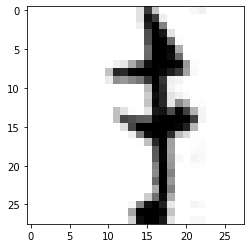

SVM prediction: ま
LR prediction: す


In [23]:
for sample, label, i in zip(X, y, range(X.shape[0])):
    if SVM_2000.predict(sample.reshape(1, -1)) == label and logreg.predict(sample.reshape(1, -1)) != label:
            LR_prediction = logreg.predict(sample.reshape(1, -1))[0]
            SVM_prediction = label
            x_missclassified = sample
            index = i
            break

plot_input(X, y, index)
print('SVM prediction:', kuzushiji_symbols[SVM_prediction])
print('LR prediction:', kuzushiji_symbols[LR_prediction])

## TO DO 11
Plot the confusion matrix for the SVM classifier and for logistic regression.
The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. In other words, $C_{i, j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. <br>
Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors.
You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation).
Try also to normalize the confusion matrix by the number of samples in each class in order to measure the accuracy on each single class. 

> We want to obtain it for the test set. 


Symbols, labels and frequencies in test set:


,お,き,す,つ,な,は,ま,や,れ,を
LABELS,0,1,2,3,4,5,6,7,8,9
COUNTS,5810,5795,5791,5812,5794,5798,5795,5798,5795,5812



 Confusion matrix - SVM and LR


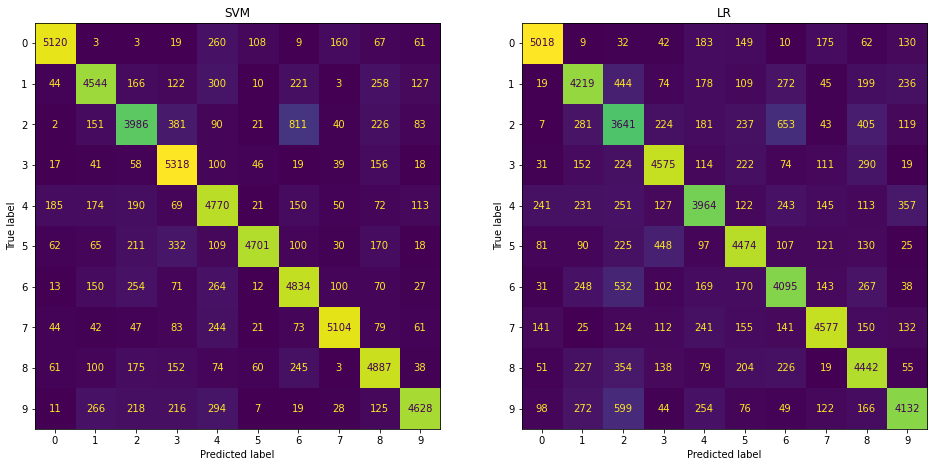


 Confusion matrix - SVM and LR (normalized) 


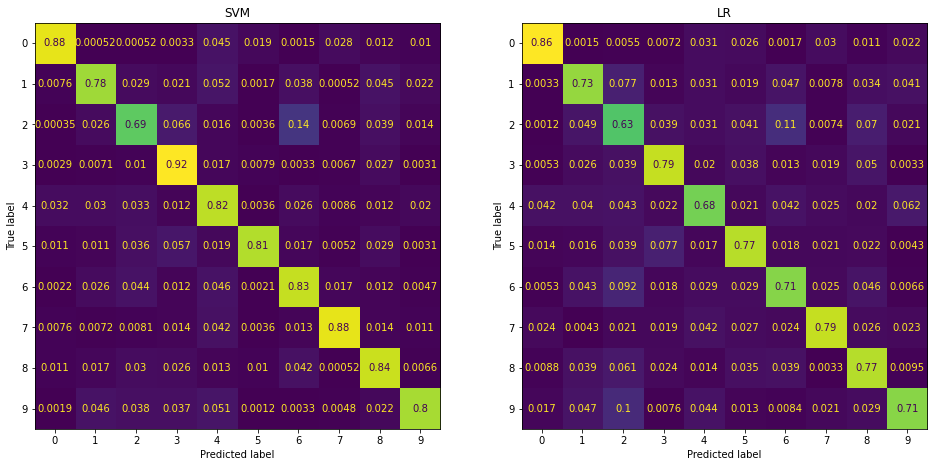

In [24]:
from IPython.display import display

np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

# labels and frequencies
u, counts = np.unique(y_test, return_counts=True)
print("Symbols, labels and frequencies in test set:")
kudf = pd.DataFrame({'LABELS':np.arange(10), 'COUNTS': counts}, index=kuzushiji_symbols)
display(kudf.T)

# confusion matrices
confusion_SVM = skm.confusion_matrix(y_test, best_SVM.predict(X_test))
confusion_LR = skm.confusion_matrix(y_test, logreg.predict(X_test))

# plot (not normalized)
print("\n Confusion matrix - SVM and LR")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

disp = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_SVM, display_labels=range(10))
disp.plot(ax=ax1)
disp.ax_.set_title('SVM')
disp.im_.colorbar.remove()

disp = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_LR, display_labels=range(10))
disp.plot(ax=ax2)
disp.ax_.set_title('LR')
disp.im_.colorbar.remove()

plt.show()

# normalization
confusion_SVM_norm = confusion_SVM /counts[:,None]
confusion_LR_norm = confusion_LR /counts[:, None]

# plot (normalized)
print("\n Confusion matrix - SVM and LR (normalized) ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

disp = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_SVM_norm, display_labels=range(10))
disp.plot(ax=ax1)
disp.ax_.set_title('SVM')
disp.im_.colorbar.remove()

disp = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_LR_norm, display_labels=range(10))
disp.plot(ax=ax2)
disp.ax_.set_title('LR')
disp.im_.colorbar.remove()

plt.show()

In [25]:
# np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

# u, counts = np.unique(y_test, return_counts=True)
# print("Labels and frequencies in test set: ", counts)

# confusion_SVM = skm.confusion_matrix(y_test, best_SVM.predict(X_test))
# print("\n Confusion matrix SVM  \n \n", confusion_SVM)
# print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

# confusion_LR = skm.confusion_matrix(y_test, logreg.predict(X_test))
# print("\n Confusion matrix LR  \n \n", confusion_LR)
# print("\n Confusion matrix LR (normalized)   \n \n", confusion_LR /counts[:,None] )

## QUESTION 4
> Have a look at the confusion matrices and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one ? Make some guesses on the possible causes.

The Kuzushiji symbol with the best accuracy is the third: つ. This character is indeed very different from all the others, so the algorithm can easily classify it. The same is true for the symbols with labels 0 and 7 (0 &#8594; お, 7 &#8594; や), although they are both somehow similar to the forth, な (they all have a more or less vertical line, a cross and a tick). This is consistent with the values in the confusion matrix, showing how the class 0 and 7 are mostly missclassified with the label 4.  

The second (す) has the worst accuracy. Indeed, from the confusion matrix, it is very often confused with the sixth (ま). This could be caused by the strong similiarity between them, in fact they both have an horizontal and vertical line, and a small circle to their left. 
